In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torchvision.models as models
from tqdm import tqdm
import torchvision.transforms as transforms
import pandas as pd

In [ ]:
#Downloading dataset and unzipping it

In [ ]:
!wget https://www.dropbox.com/s/07h7wtvau0ilr10/KTH_64.zip?dl=0

In [ ]:
!unzip KTH_64.zip?dl=0

In [ ]:
#MODELS and Implementations

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_ch, hidden_ch, kernel_size, bias=True, pool=True):
        super().__init__()

        self.input_ch = input_ch
        self.hidden_ch = hidden_ch
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2, kernel_size // 2
        self.bias = bias


        self.conv_XH = nn.Sequential(
            nn.Conv2d(in_channels=self.input_ch + self.hidden_ch,
                      out_channels=4 * self.hidden_ch,
                      kernel_size=self.kernel_size,
                      padding=self.padding, bias=self.bias
                      ),
            nn.BatchNorm2d(4 * self.hidden_ch)
        )

    def forward(self, x, hc):
        h_cur, c_cur = hc

        combined = torch.cat([x, h_cur], dim=1)
        gates = self.conv_XH(combined)

        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cell_gate = c_cur * f_t + i_t * g_t

        hidden_gate = o_t * torch.tanh(cell_gate)

        return (hidden_gate, cell_gate)

In [179]:
class ConvBlock(nn.Module):
    """
    Encapuslation of a convolutional block (conv + activation + pooling)
    """
    def __init__(self, in_ch, out_ch, k_size, pool=False):
        super().__init__()
        self.module = nn.Sequential()
        self.module.add_module("Conv", nn.Conv2d(in_ch, out_ch, k_size))
        self.module.add_module("Norm", nn.BatchNorm2d(out_ch))
        self.module.add_module("Act", nn.ReLU())
        if pool:
            self.module.add_module("Pool", nn.MaxPool2d(kernel_size=2))
    
    def forward(self, x):
        y = self.module(x)
        return y

In [180]:
class RecurrentModule(nn.Module):
    def __init__(self, recurrent_cell, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_size = hidden_dim
        self.input_size = input_dim
        rcells = []
        for i in range(num_layers):
            in_size = input_dim if i == 0 else hidden_dim
            rcells.append(recurrent_cell(in_size, hidden_dim))
        
        self.num_layers = num_layers
        self.cells = nn.ModuleList(rcells)
    
    def forward(self, x):
        pass

In [220]:
class ConvolutionEncoder(nn.Module):
    def __init__(self, in_ch, out_ch, k_size):
        super().__init__()

        self.model = nn.Sequential(
            ConvBlock(in_ch, 16, k_size, pool=True),
            ConvBlock(16, 32, k_size, pool=True),
            ConvBlock(32, 64, k_size, pool=True),
            ConvBlock(64, out_ch, k_size, pool=True),


        )

    def forward(self, x):
        return self.model(x)

In [221]:
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [222]:
#Set the device to cuda

In [183]:
set_random_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [224]:
#Models implementations

In [225]:
#Helper function to convert the sequence of images to dataframes
def get_seq_df(filepath):

    """
    input: filepath
    output: dictonary of image (person, frame, label, path)
    """

    persons_dict = {
        "person": [],
        "frame": [],
        "label": [],
        "path": [],
    }

    with open(filepath) as f:
        lines = f.readlines()
    #Real data starts from line 21
    lines = lines
    lines = [line.strip() for line in lines[21:] if line.strip()]

    for line in lines:
        line_split_list = line.split("\t")
        person = line_split_list[0].split("_")[0]
        label = line_split_list[0].split("_")[1]
        frames = line_split_list[-1].split(",")
        path = label + "/" + line_split_list[0]

        for frame in frames:
            persons_dict["person"].append(person.strip())
            persons_dict["frame"].append(frame.strip())
            persons_dict["label"].append(label.strip())
            persons_dict["path"].append(path.strip())
    
    return pd.DataFrame.from_dict(persons_dict)

In [226]:
#Read the dataset from sequences text file and convert it to dataframe and remove missing values

In [227]:
dataframe = get_seq_df("sequences.txt")
dataframe = dataframe.drop(dataframe.loc[dataframe["frame"] == "*missing*"].index).reset_index(drop=True)

In [228]:
# Helping functions to read the images and converting images to stack of numpy arrays

In [229]:

def read_image(path):
    return np.array(Image.open(path))


def seq2np(seq, base_dir, path, seq_len, transform_func=None):
    frames_list = []
    start = int(seq.split("-")[0]) - 1
    end = int(seq.split("-")[1])
    
    #Check if end value is greater than start value with sequence length
    if end > start + seq_len:
        end = start + seq_len

    all_frames = sorted(os.listdir(os.path.join(base_dir, path)))
    seq_frames = all_frames[start:end]

    for frame_path in seq_frames:
        array = read_image(os.path.join(base_dir, path, frame_path))
        if transform_func:
            array = transform_func(array)
        array = np.expand_dims(array, 0)
        frames_list.append(array)

    return np.concatenate(frames_list, 0)


In [230]:

class KTH(Dataset):
    def __init__(self, dataframe, base_dir, seq_len=20, transform_func=None, mode="train"):
        if mode == "train":
            persons = "12, 13, 14, 15, 16, 17, 18"
        elif mode == "valid":
            persons = "20, 21, 23, 24, 25, 01, 04"
        elif mode == "test":
            persons = "02, 03, 05, 06, 07, 08, 09, 10"

        persons = ["person" + p.strip() for p in persons.split(",")]

        labels = {
            "boxing": 0,
            "handclapping": 1,
            "handwaving": 2,
            "jogging": 3,
            "running": 4,
            "walking": 5,
        }

        self.dataframe = dataframe.loc[dataframe["person"].isin(persons)].reset_index(drop=True)
        self.dataframe["label"] = self.dataframe["label"].map(labels)
        self.base_dir = base_dir
        self.transform_func = transform_func
        self.seq_len = seq_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        seq = self.dataframe.iloc[idx, 1]
        label = self.dataframe.iloc[idx, 2]
        path = self.dataframe.iloc[idx, 3]

        frames = seq2np(seq, self.base_dir, path, self.seq_len, self.transform_func)

        return frames, label


In [231]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
       
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass only to get logits/output
        outputs = model(images)
        outputs = outputs.to(device)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:

        images = images.to(device)
        labels = labels.to(device)
        
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    epochs = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        epochs.append(epoch+1)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, epochs


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


In [232]:
#Conv Encoder output dims
c_encoder = 128 * 2 * 2


In [233]:
class RecognitionKTHSimple(nn.Module):
    def __init__(self, recurrent_module, number_of_classes=6):
        super().__init__()
        self.encoder = ConvolutionEncoder(3, 128, 3)
        self.recurrent_module = recurrent_module
        self.classifier = nn.Linear(self.recurrent_module.hidden_size, number_of_classes)

    def forward(self, x):
        x = torch.permute(x, (1, 0, 2, 3, 4)).contiguous()
        seq_len, batch_size, n_channels, n_rows, n_cols = x.shape

        #Initializing the states with zeros (can also be random values)

        h = [torch.zeros(batch_size, self.recurrent_module.hidden_size).to(device) for _ in
             range(self.recurrent_module.num_layers)]
        c = [torch.zeros(batch_size, self.recurrent_module.hidden_size).to(device) for _ in
             range(self.recurrent_module.num_layers)]

        #Passing the input through encoder first; then use the recurrent cell to geterate gates h,c
        #store the h gate and pass it to classifier
        recurrent_out = []

        for i in range(seq_len):
            recurrent_input = self.encoder(x[i]).view(batch_size, Conv_ENC_OUT)
            for j, recurrent_cell in enumerate(self.recurrent_module.cells):
                h[j], c[j] = recurrent_cell(recurrent_input, (h[j], c[j]))
                recurrent_input = h[j]
            recurrent_out.append(recurrent_input)

        #Convert it to 1d
        recurrent_out = torch.stack(recurrent_out, dim=1)
        #Pass through classifier layer
        y = self.classifier(recurrent_out[:, -1, :])

        return y

In [234]:
# Create Datasets
seq_len = 20
base_dir = "KTH_64/processed"
transform_func = transforms.Compose([
            transforms.ToTensor(),                         
        ])

train_dataset = KTH(dataframe, base_dir, seq_len, transform_func, mode="train")
valid_dataset = KTH(dataframe, base_dir, seq_len, transform_func, mode="valid")
test_dataset = KTH(dataframe, base_dir, seq_len, transform_func, mode="test")

In [235]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32, 
                                           shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=32, 
                                           shuffle=False) 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=32,
                                          shuffle=False)

In [236]:
def get_plots(train_loss, val_loss, loss_iters, valid_acc, epochs):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress")

    epochs = np.arange(len(train_loss)) + 1
    ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_title("Loss Curves")

    epochs = np.arange(len(val_loss)) + 1
    ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Accuracy (%)")
    ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

    plt.show()
    

**LSTM Cell Training**

In [238]:
import math
r_cell = nn.LSTMCell
r_module = RecurrentModule(r_cell, c_encoder, 128, 1)
model_2 = RecognitionKTHSimple(r_module)
model_2 = model_2.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_2.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.25)
EPOCHS = 40
train_loss, val_loss, loss_iters, valid_acc, epochs = train_model(
        model=model_2, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS)

Epoch 1 Iter 21: loss 1.14223. : 100%|██████████| 21/21 [00:04<00:00,  5.12it/s]


Epoch 1/40
    Train loss: 1.46054
    Valid loss: 1.79364
    Accuracy: 16.666666666666664%




Epoch 2 Iter 21: loss 1.04386. : 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


Epoch 2/40
    Train loss: 1.07567
    Valid loss: 1.31343
    Accuracy: 41.220238095238095%




Epoch 3 Iter 21: loss 0.90475. : 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


Epoch 3/40
    Train loss: 0.86698
    Valid loss: 1.09343
    Accuracy: 55.50595238095239%




Epoch 4 Iter 21: loss 0.80844. : 100%|██████████| 21/21 [00:04<00:00,  5.14it/s]


Epoch 4/40
    Train loss: 0.73993
    Valid loss: 0.96078
    Accuracy: 59.672619047619044%




Epoch 5 Iter 21: loss 0.58531. : 100%|██████████| 21/21 [00:04<00:00,  5.17it/s]


Epoch 5/40
    Train loss: 0.62071
    Valid loss: 0.86625
    Accuracy: 64.73214285714286%




Epoch 6 Iter 21: loss 0.78076. : 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]


Epoch 6/40
    Train loss: 0.58321
    Valid loss: 0.94525
    Accuracy: 57.291666666666664%




Epoch 7 Iter 21: loss 0.57798. : 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch 7/40
    Train loss: 0.47254
    Valid loss: 0.85404
    Accuracy: 61.16071428571429%




Epoch 8 Iter 21: loss 0.56180. : 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch 8/40
    Train loss: 0.42844
    Valid loss: 0.89327
    Accuracy: 61.904761904761905%




Epoch 9 Iter 21: loss 0.41181. : 100%|██████████| 21/21 [00:04<00:00,  5.14it/s]


Epoch 9/40
    Train loss: 0.40375
    Valid loss: 0.85852
    Accuracy: 61.458333333333336%




Epoch 10 Iter 21: loss 0.44523. : 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch 10/40
    Train loss: 0.38334
    Valid loss: 0.79398
    Accuracy: 63.988095238095234%




Epoch 11 Iter 21: loss 0.28632. : 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch 11/40
    Train loss: 0.36253
    Valid loss: 0.83562
    Accuracy: 62.202380952380956%




Epoch 12 Iter 21: loss 0.46142. : 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch 12/40
    Train loss: 0.35224
    Valid loss: 0.81678
    Accuracy: 62.797619047619044%




Epoch 13 Iter 21: loss 0.23920. : 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


Epoch 13/40
    Train loss: 0.32749
    Valid loss: 0.80596
    Accuracy: 63.83928571428571%




Epoch 14 Iter 21: loss 0.30966. : 100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


Epoch 14/40
    Train loss: 0.31473
    Valid loss: 0.80902
    Accuracy: 63.39285714285714%




Epoch 15 Iter 21: loss 0.47155. : 100%|██████████| 21/21 [00:04<00:00,  5.10it/s]


Epoch 15/40
    Train loss: 0.32056
    Valid loss: 0.81396
    Accuracy: 63.541666666666664%




Epoch 16 Iter 21: loss 0.32374. : 100%|██████████| 21/21 [00:04<00:00,  5.01it/s]


Epoch 16/40
    Train loss: 0.31131
    Valid loss: 0.89098
    Accuracy: 58.63095238095239%




Epoch 17 Iter 21: loss 0.26488. : 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch 17/40
    Train loss: 0.3057
    Valid loss: 0.80599
    Accuracy: 64.28571428571429%




Epoch 18 Iter 21: loss 0.25645. : 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch 18/40
    Train loss: 0.30362
    Valid loss: 0.82488
    Accuracy: 62.05357142857143%




Epoch 19 Iter 21: loss 0.44876. : 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


Epoch 19/40
    Train loss: 0.29622
    Valid loss: 0.78933
    Accuracy: 64.73214285714286%




Epoch 20 Iter 21: loss 0.36111. : 100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


Epoch 20/40
    Train loss: 0.29048
    Valid loss: 0.85572
    Accuracy: 62.648809523809526%




Epoch 21 Iter 21: loss 0.28742. : 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]


Epoch 21/40
    Train loss: 0.2949
    Valid loss: 0.81987
    Accuracy: 63.69047619047619%




Epoch 22 Iter 21: loss 0.26263. : 100%|██████████| 21/21 [00:04<00:00,  5.12it/s]


Epoch 22/40
    Train loss: 0.28984
    Valid loss: 0.82348
    Accuracy: 61.75595238095239%




Epoch 23 Iter 21: loss 0.37591. : 100%|██████████| 21/21 [00:04<00:00,  5.14it/s]


Epoch 23/40
    Train loss: 0.29008
    Valid loss: 0.81597
    Accuracy: 62.05357142857143%




Epoch 24 Iter 21: loss 0.39812. : 100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


Epoch 24/40
    Train loss: 0.28815
    Valid loss: 0.78731
    Accuracy: 64.13690476190477%




Epoch 25 Iter 21: loss 0.43985. : 100%|██████████| 21/21 [00:04<00:00,  5.14it/s]


Epoch 25/40
    Train loss: 0.28887
    Valid loss: 0.84543
    Accuracy: 62.05357142857143%




Epoch 26 Iter 21: loss 0.31873. : 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Epoch 26/40
    Train loss: 0.28803
    Valid loss: 0.83674
    Accuracy: 61.75595238095239%




Epoch 27 Iter 21: loss 0.26203. : 100%|██████████| 21/21 [00:04<00:00,  5.03it/s]


Epoch 27/40
    Train loss: 0.2863
    Valid loss: 0.8641
    Accuracy: 61.60714285714286%




Epoch 28 Iter 21: loss 0.25271. : 100%|██████████| 21/21 [00:04<00:00,  5.17it/s]


Epoch 28/40
    Train loss: 0.28265
    Valid loss: 0.82351
    Accuracy: 62.797619047619044%




Epoch 29 Iter 21: loss 0.43493. : 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]


Epoch 29/40
    Train loss: 0.28771
    Valid loss: 0.80281
    Accuracy: 62.94642857142857%




Epoch 30 Iter 21: loss 0.33749. : 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]


Epoch 30/40
    Train loss: 0.28468
    Valid loss: 0.80188
    Accuracy: 64.13690476190477%




Epoch 31 Iter 21: loss 0.32154. : 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]


Epoch 31/40
    Train loss: 0.28442
    Valid loss: 0.83357
    Accuracy: 62.05357142857143%




Epoch 32 Iter 21: loss 0.45692. : 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]


Epoch 32/40
    Train loss: 0.28744
    Valid loss: 0.82072
    Accuracy: 62.5%




Epoch 33 Iter 21: loss 0.31378. : 100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


Epoch 33/40
    Train loss: 0.28881
    Valid loss: 0.86524
    Accuracy: 60.11904761904761%




Epoch 34 Iter 21: loss 0.20835. : 100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


Epoch 34/40
    Train loss: 0.28476
    Valid loss: 0.86005
    Accuracy: 60.26785714285714%




Epoch 35 Iter 21: loss 0.32658. : 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


Epoch 35/40
    Train loss: 0.28252
    Valid loss: 0.8353
    Accuracy: 61.904761904761905%




Epoch 36 Iter 21: loss 0.38056. : 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


Epoch 36/40
    Train loss: 0.28982
    Valid loss: 0.82313
    Accuracy: 63.988095238095234%




Epoch 37 Iter 21: loss 0.25696. : 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch 37/40
    Train loss: 0.2856
    Valid loss: 0.85352
    Accuracy: 61.16071428571429%




Epoch 38 Iter 21: loss 0.23276. : 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


Epoch 38/40
    Train loss: 0.28648
    Valid loss: 0.82604
    Accuracy: 62.5%




Epoch 39 Iter 21: loss 0.28523. : 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


Epoch 39/40
    Train loss: 0.28398
    Valid loss: 0.79763
    Accuracy: 63.83928571428571%




Epoch 40 Iter 21: loss 0.54211. : 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]

Epoch 40/40
    Train loss: 0.29099
    Valid loss: 0.84781
    Accuracy: 61.75595238095239%


Training completed


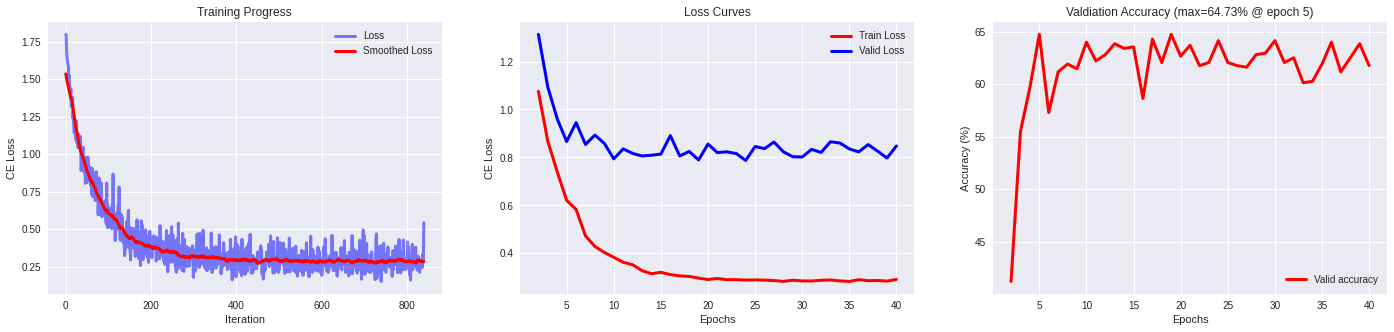

In [239]:
get_plots(train_loss, val_loss, loss_iters, valid_acc, epochs)

In [240]:
eval_model(model_2, test_loader, criterion, device)


(55.859375, 1.0511587709188461)

The training loss starts very high and gradually decreases and resembles that of the good model that does not overfit. 
The loss curves from the training and validation dataset seems to show that the model is overfitting as it is expected (LSTM is prone to overfitting if provided with less data). 
The validation accuracy graph show that model is learning starting from a base value of 38ish and following upto a maximum of 65% and staying around the same max percentage.

**GRU Cell Training**

In [241]:
import math
r_cell = nn.GRUCell
r_module = RecurrentModule(r_cell, c_encoder, 128, 1)
model_3 = RecognitionKTHSimple(recurrent_module)
model_3 = model_3.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_3.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
EPOCHS = 40
train_loss2, val_loss2, loss_iters2, valid_acc2, epochs = train_model(
        model=model_3, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=EPOCHS)

Epoch 1 Iter 21: loss 1.58892. : 100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


Epoch 1/40
    Train loss: 1.72316
    Valid loss: 1.89183
    Accuracy: 16.666666666666664%




Epoch 2 Iter 21: loss 1.34432. : 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]


Epoch 2/40
    Train loss: 1.39943
    Valid loss: 1.52805
    Accuracy: 36.904761904761905%




Epoch 3 Iter 21: loss 1.31490. : 100%|██████████| 21/21 [00:04<00:00,  5.03it/s]


Epoch 3/40
    Train loss: 1.24266
    Valid loss: 1.37055
    Accuracy: 47.32142857142857%




Epoch 4 Iter 21: loss 1.11931. : 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


Epoch 4/40
    Train loss: 1.13205
    Valid loss: 1.29131
    Accuracy: 44.642857142857146%




Epoch 5 Iter 21: loss 1.02023. : 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Epoch 5/40
    Train loss: 1.04466
    Valid loss: 1.19976
    Accuracy: 46.13095238095239%




Epoch 6 Iter 21: loss 1.00046. : 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


Epoch 6/40
    Train loss: 0.9797
    Valid loss: 1.17973
    Accuracy: 41.964285714285715%




Epoch 7 Iter 21: loss 0.93149. : 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


Epoch 7/40
    Train loss: 0.94751
    Valid loss: 1.14693
    Accuracy: 52.67857142857143%




Epoch 8 Iter 21: loss 1.05403. : 100%|██████████| 21/21 [00:04<00:00,  5.03it/s]


Epoch 8/40
    Train loss: 0.93289
    Valid loss: 1.13779
    Accuracy: 55.952380952380956%




Epoch 9 Iter 21: loss 0.91590. : 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Epoch 9/40
    Train loss: 0.91294
    Valid loss: 1.12805
    Accuracy: 54.01785714285714%




Epoch 10 Iter 21: loss 0.89696. : 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]


Epoch 10/40
    Train loss: 0.8956
    Valid loss: 1.1133
    Accuracy: 55.654761904761905%




Epoch 11 Iter 21: loss 0.86029. : 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch 11/40
    Train loss: 0.87537
    Valid loss: 1.11868
    Accuracy: 53.125%




Epoch 12 Iter 21: loss 0.97361. : 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


Epoch 12/40
    Train loss: 0.87062
    Valid loss: 1.11121
    Accuracy: 56.25%




Epoch 13 Iter 21: loss 0.80458. : 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]


Epoch 13/40
    Train loss: 0.8588
    Valid loss: 1.11737
    Accuracy: 55.208333333333336%




Epoch 14 Iter 21: loss 0.92791. : 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Epoch 14/40
    Train loss: 0.85798
    Valid loss: 1.09628
    Accuracy: 58.779761904761905%




Epoch 15 Iter 21: loss 0.79034. : 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]


Epoch 15/40
    Train loss: 0.85643
    Valid loss: 1.10008
    Accuracy: 57.738095238095234%




Epoch 16 Iter 21: loss 0.92727. : 100%|██████████| 21/21 [00:04<00:00,  5.03it/s]


Epoch 16/40
    Train loss: 0.85232
    Valid loss: 1.09637
    Accuracy: 56.69642857142857%




Epoch 17 Iter 21: loss 0.71088. : 100%|██████████| 21/21 [00:04<00:00,  5.10it/s]


Epoch 17/40
    Train loss: 0.85006
    Valid loss: 1.12729
    Accuracy: 53.720238095238095%




Epoch 18 Iter 21: loss 0.86975. : 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


Epoch 18/40
    Train loss: 0.84379
    Valid loss: 1.09605
    Accuracy: 56.845238095238095%




Epoch 19 Iter 21: loss 0.87445. : 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


Epoch 19/40
    Train loss: 0.84227
    Valid loss: 1.11378
    Accuracy: 54.91071428571429%




Epoch 20 Iter 21: loss 0.91794. : 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]


Epoch 20/40
    Train loss: 0.84913
    Valid loss: 1.09808
    Accuracy: 56.845238095238095%




Epoch 21 Iter 21: loss 0.91222. : 100%|██████████| 21/21 [00:04<00:00,  4.95it/s]


Epoch 21/40
    Train loss: 0.84628
    Valid loss: 1.09143
    Accuracy: 58.333333333333336%




Epoch 22 Iter 21: loss 0.79799. : 100%|██████████| 21/21 [00:04<00:00,  4.88it/s]


Epoch 22/40
    Train loss: 0.85181
    Valid loss: 1.18826
    Accuracy: 50.0%




Epoch 23 Iter 21: loss 0.75402. : 100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


Epoch 23/40
    Train loss: 0.84248
    Valid loss: 1.09569
    Accuracy: 57.14285714285714%




Epoch 24 Iter 21: loss 0.86425. : 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


Epoch 24/40
    Train loss: 0.84079
    Valid loss: 1.12178
    Accuracy: 54.613095238095234%




Epoch 25 Iter 21: loss 0.88214. : 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]


Epoch 25/40
    Train loss: 0.84731
    Valid loss: 1.09327
    Accuracy: 58.779761904761905%




Epoch 26 Iter 21: loss 0.78373. : 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Epoch 26/40
    Train loss: 0.84769
    Valid loss: 1.11007
    Accuracy: 56.25%




Epoch 27 Iter 21: loss 0.88930. : 100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Epoch 27/40
    Train loss: 0.84544
    Valid loss: 1.11543
    Accuracy: 54.613095238095234%




Epoch 28 Iter 21: loss 0.84328. : 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


Epoch 28/40
    Train loss: 0.84206
    Valid loss: 1.09307
    Accuracy: 58.03571428571429%




Epoch 29 Iter 21: loss 0.93111. : 100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


Epoch 29/40
    Train loss: 0.84339
    Valid loss: 1.10222
    Accuracy: 54.46428571428571%




Epoch 30 Iter 21: loss 0.92024. : 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]


Epoch 30/40
    Train loss: 0.84968
    Valid loss: 1.08824
    Accuracy: 58.48214285714286%




Epoch 31 Iter 21: loss 0.99569. : 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch 31/40
    Train loss: 0.84732
    Valid loss: 1.09987
    Accuracy: 58.03571428571429%




Epoch 32 Iter 21: loss 0.82234. : 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Epoch 32/40
    Train loss: 0.83659
    Valid loss: 1.14224
    Accuracy: 54.01785714285714%




Epoch 33 Iter 21: loss 0.85233. : 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


Epoch 33/40
    Train loss: 0.84288
    Valid loss: 1.14827
    Accuracy: 51.488095238095234%




Epoch 34 Iter 21: loss 0.73402. : 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch 34/40
    Train loss: 0.84735
    Valid loss: 1.0974
    Accuracy: 58.333333333333336%




Epoch 35 Iter 21: loss 0.80533. : 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch 35/40
    Train loss: 0.84498
    Valid loss: 1.09034
    Accuracy: 58.333333333333336%




Epoch 36 Iter 21: loss 0.85121. : 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Epoch 36/40
    Train loss: 0.84515
    Valid loss: 1.08574
    Accuracy: 59.375%




Epoch 37 Iter 21: loss 0.86115. : 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch 37/40
    Train loss: 0.85122
    Valid loss: 1.09268
    Accuracy: 58.63095238095239%




Epoch 38 Iter 21: loss 0.78845. : 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Epoch 38/40
    Train loss: 0.8415
    Valid loss: 1.10262
    Accuracy: 57.58928571428571%




Epoch 39 Iter 21: loss 0.79271. : 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Epoch 39/40
    Train loss: 0.84392
    Valid loss: 1.09016
    Accuracy: 58.333333333333336%




Epoch 40 Iter 21: loss 0.89112. : 100%|██████████| 21/21 [00:04<00:00,  5.17it/s]

Epoch 40/40
    Train loss: 0.84293
    Valid loss: 1.10343
    Accuracy: 56.547619047619044%


Training completed


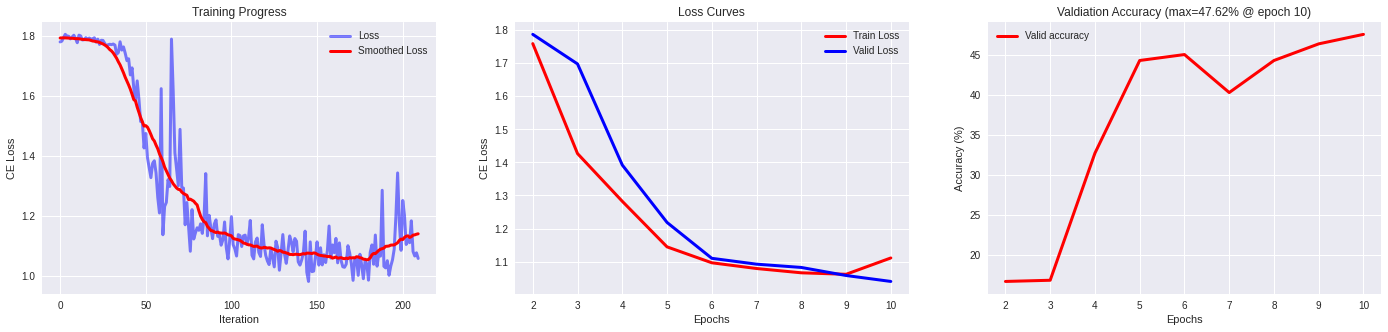

In [244]:
get_plots(train_loss_2, val_loss_2, loss_iters_2, valid_acc_2, epochs)

In [245]:
eval_model(model_3, test_loader, criterion, device)

(45.57291666666667, 1.3049366424481075)

These graphs show that model is not overfitting and is following the good fit as training loss is followed by validation loss. The accuracy is a bit off.

In [248]:
class RecognitionConvLSTM(nn.Module):
    def __init__(self, hidden_ch, n_actions=6):
        super().__init__()
        self.hidden_ch = hidden_ch
        self.conv_lstm = ConvLSTMCell(3, hidden_ch, 3)
        self.classifier = nn.Linear(16 * 64 * 64, n_actions)

    def forward(self, x):
        x = torch.permute(x, (1, 0, 2, 3, 4)).contiguous()
        seq_len, batch_size, n_channels, n_rows, n_cols = x.shape

        # Initializing the states with zeros (can also be random values)

        h = torch.zeros(batch_size, self.hidden_ch, 64, 64).to(device)
        c = torch.zeros(batch_size, self.hidden_ch, 64, 64).to(device)

        # This time we dont need to pass the input through encder and then LSTM/GRU

        for i in range(seq_len):
            h, c = self.conv_lstm(x[i], (h, c))

        y = self.classifier(h.view(batch_size, -1))

        return y


In [217]:
model_4 = RecognitionConvLSTM(16)
model_4 = model_4.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_4.parameters(), lr=3e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

train_loss_3, val_loss_3, loss_iters_3, valid_acc_3, epochs_3 = train_model(
        model=model_4, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=40
)

Epoch 1 Iter 21: loss 1.61528. : 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]


Epoch 1/40
    Train loss: 1.89528
    Valid loss: 1.79337
    Accuracy: 15.922619047619047%




Epoch 2 Iter 21: loss 1.39459. : 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch 2/40
    Train loss: 1.23484
    Valid loss: 1.61039
    Accuracy: 29.464285714285715%




Epoch 3 Iter 21: loss 0.83333. : 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch 3/40
    Train loss: 0.8491
    Valid loss: 1.30065
    Accuracy: 38.839285714285715%




Epoch 4 Iter 21: loss 0.58608. : 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]


Epoch 4/40
    Train loss: 0.55011
    Valid loss: 1.95089
    Accuracy: 28.720238095238095%




Epoch 5 Iter 21: loss 0.39126. : 100%|██████████| 21/21 [00:04<00:00,  4.40it/s]


Epoch 5/40
    Train loss: 0.34057
    Valid loss: 1.39473
    Accuracy: 36.75595238095239%




Epoch 6 Iter 21: loss 0.24268. : 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


Epoch 6/40
    Train loss: 0.226
    Valid loss: 1.40722
    Accuracy: 38.69047619047619%




Epoch 7 Iter 21: loss 0.13803. : 100%|██████████| 21/21 [00:04<00:00,  4.21it/s]


Epoch 7/40
    Train loss: 0.19981
    Valid loss: 1.41269
    Accuracy: 37.202380952380956%




Epoch 8 Iter 21: loss 0.25525. : 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]


Epoch 8/40
    Train loss: 0.19128
    Valid loss: 1.39924
    Accuracy: 35.267857142857146%




Epoch 9 Iter 21: loss 0.11821. : 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]


Epoch 9/40
    Train loss: 0.20544
    Valid loss: 1.35784
    Accuracy: 38.095238095238095%




Epoch 10 Iter 21: loss 0.24346. : 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]


Epoch 10/40
    Train loss: 0.1448
    Valid loss: 1.3412
    Accuracy: 38.392857142857146%




Epoch 11 Iter 21: loss 0.30009. : 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]


Epoch 11/40
    Train loss: 0.14095
    Valid loss: 1.2839
    Accuracy: 39.58333333333333%




Epoch 12 Iter 21: loss 0.17501. : 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]


Epoch 12/40
    Train loss: 0.13713
    Valid loss: 1.29614
    Accuracy: 43.30357142857143%




Epoch 13 Iter 21: loss 0.12075. : 100%|██████████| 21/21 [00:04<00:00,  4.24it/s]


Epoch 13/40
    Train loss: 0.12967
    Valid loss: 1.373
    Accuracy: 38.24404761904761%




Epoch 14 Iter 21: loss 0.10608. : 100%|██████████| 21/21 [00:04<00:00,  4.25it/s]


Epoch 14/40
    Train loss: 0.15819
    Valid loss: 1.36569
    Accuracy: 36.75595238095239%




Epoch 15 Iter 21: loss 0.15051. : 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]


Epoch 15/40
    Train loss: 0.11107
    Valid loss: 1.34203
    Accuracy: 36.75595238095239%




Epoch 16 Iter 21: loss 0.13887. : 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]


Epoch 16/40
    Train loss: 0.13602
    Valid loss: 1.36546
    Accuracy: 41.220238095238095%




Epoch 17 Iter 21: loss 0.08745. : 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]


Epoch 17/40
    Train loss: 0.11479
    Valid loss: 1.35648
    Accuracy: 40.327380952380956%




Epoch 18 Iter 21: loss 0.12496. : 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


Epoch 18/40
    Train loss: 0.12396
    Valid loss: 1.31568
    Accuracy: 41.66666666666667%




Epoch 19 Iter 21: loss 0.11935. : 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]


Epoch 19/40
    Train loss: 0.13014
    Valid loss: 1.36139
    Accuracy: 37.94642857142857%




Epoch 20 Iter 21: loss 0.09527. : 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]


Epoch 20/40
    Train loss: 0.11777
    Valid loss: 1.34024
    Accuracy: 39.732142857142854%




Epoch 21 Iter 21: loss 0.14680. : 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch 21/40
    Train loss: 0.13441
    Valid loss: 1.3541
    Accuracy: 37.648809523809526%




Epoch 22 Iter 21: loss 0.11982. : 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 22/40
    Train loss: 0.11795
    Valid loss: 1.33346
    Accuracy: 38.69047619047619%




Epoch 23 Iter 21: loss 0.15696. : 100%|██████████| 21/21 [00:04<00:00,  4.36it/s]


Epoch 23/40
    Train loss: 0.14445
    Valid loss: 1.30483
    Accuracy: 42.11309523809524%




Epoch 24 Iter 21: loss 0.18735. : 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]


Epoch 24/40
    Train loss: 0.13751
    Valid loss: 1.25699
    Accuracy: 42.70833333333333%




Epoch 25 Iter 21: loss 0.33108. : 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 25/40
    Train loss: 0.14451
    Valid loss: 1.36153
    Accuracy: 40.773809523809526%




Epoch 26 Iter 21: loss 0.08203. : 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]


Epoch 26/40
    Train loss: 0.11779
    Valid loss: 1.33584
    Accuracy: 37.797619047619044%




Epoch 27 Iter 21: loss 0.10161. : 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]


Epoch 27/40
    Train loss: 0.12996
    Valid loss: 1.34905
    Accuracy: 37.351190476190474%




Epoch 28 Iter 21: loss 0.12563. : 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


Epoch 28/40
    Train loss: 0.1331
    Valid loss: 1.35079
    Accuracy: 38.24404761904761%




Epoch 29 Iter 21: loss 0.12472. : 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]


Epoch 29/40
    Train loss: 0.12313
    Valid loss: 1.41057
    Accuracy: 36.30952380952381%




Epoch 30 Iter 21: loss 0.09730. : 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


Epoch 30/40
    Train loss: 0.11245
    Valid loss: 1.26118
    Accuracy: 44.49404761904761%




Epoch 31 Iter 21: loss 0.09341. : 100%|██████████| 21/21 [00:04<00:00,  4.40it/s]


Epoch 31/40
    Train loss: 0.11345
    Valid loss: 1.31349
    Accuracy: 40.17857142857143%




Epoch 32 Iter 21: loss 0.09317. : 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]


Epoch 32/40
    Train loss: 0.10869
    Valid loss: 1.34472
    Accuracy: 41.220238095238095%




Epoch 33 Iter 21: loss 0.15158. : 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


Epoch 33/40
    Train loss: 0.13201
    Valid loss: 1.31761
    Accuracy: 39.285714285714285%




Epoch 34 Iter 21: loss 0.33177. : 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]


Epoch 34/40
    Train loss: 0.12878
    Valid loss: 1.28555
    Accuracy: 42.857142857142854%




Epoch 35 Iter 21: loss 0.32561. : 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch 35/40
    Train loss: 0.13437
    Valid loss: 1.27725
    Accuracy: 38.98809523809524%




Epoch 36 Iter 21: loss 0.10977. : 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]


Epoch 36/40
    Train loss: 0.11435
    Valid loss: 1.31945
    Accuracy: 39.43452380952381%




Epoch 37 Iter 21: loss 0.12992. : 100%|██████████| 21/21 [00:05<00:00,  4.19it/s]


Epoch 37/40
    Train loss: 0.12888
    Valid loss: 1.30825
    Accuracy: 43.00595238095239%




Epoch 38 Iter 21: loss 0.32446. : 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


Epoch 38/40
    Train loss: 0.13309
    Valid loss: 1.41671
    Accuracy: 37.05357142857143%




Epoch 39 Iter 21: loss 0.13044. : 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]


Epoch 39/40
    Train loss: 0.11963
    Valid loss: 1.31034
    Accuracy: 38.839285714285715%




Epoch 40 Iter 21: loss 0.50787. : 100%|██████████| 21/21 [00:04<00:00,  4.47it/s]

Epoch 40/40
    Train loss: 0.12961
    Valid loss: 1.40832
    Accuracy: 39.732142857142854%


Training completed


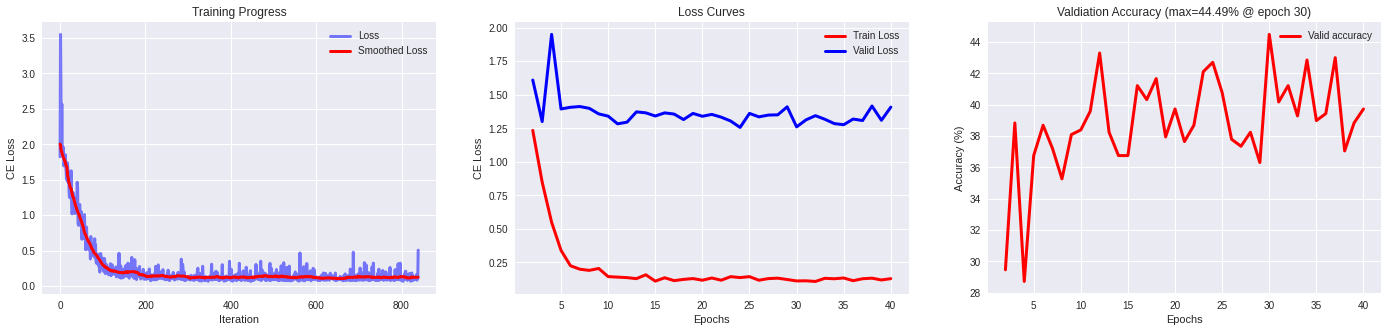

In [246]:
get_plots(train_loss_3, val_loss_3, loss_iters_3, valid_acc_3, epochs_3)


In [247]:
eval_model(model_4, test_loader, criterion, device)


(37.890625, 1.3391720205545425)

The training progress show that the CONV model is learning well on training dataset. The training and validation loss show that the model is overfitting with the same accuracy and pattern as LSTM.

**Comparison**

These graphs show that LSTM and ConvLSTM show same pattern and overfit on this dataset. As LSTM is prone to overfitting if provided with not-enough data. 
The GRU is handling the overfitting problem very well as it requires less data and just exposes the hidden states without giving extra information